<a href="https://colab.research.google.com/github/yellowssnake/221_zlotin/blob/main/assets/Notebooks/time_series_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries anomaly detection using an Autoencoder

## Introduction

This script demonstrates how you can use a reconstruction convolutional
autoencoder model to detect anomalies in timeseries data.

## Setup

In [1]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

## Load the data

We will use the [Numenta Anomaly Benchmark(NAB)](https://github.com/numenta/NAB) dataset. It provides artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics.

We will use the `nyc_taxi.csv` Number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm. The raw data is from the NYC Taxi and Limousine Commission. The data file included here consists of aggregating the total number of taxi passengers into 30 minute buckets.

In [2]:
import plotly.graph_objs as go
import pandas as pd

# Load the dataset
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
df = pd.read_csv(url, parse_dates=True, index_col="timestamp")

# Define the anomalies
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# Create the plot
fig = go.Figure()

# Add the main trace
fig.add_trace(go.Scatter(x=df.index, y=df['value'], mode='lines', name='Taxi Passengers'))

# Add anomaly points with unique markers
markers = ['circle', 'square', 'diamond', 'triangle-up', 'triangle-down']
for (label, date), marker in zip(anomalies.items(), markers):
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df.loc[date]['value']],
        mode='markers+text',
        name=label,
        text=label,
        textposition="top center",
        marker=dict(symbol=marker, size=10, color='red')
    ))

# Update layout
fig.update_layout(
    title='New York City Taxi Passengers with Anomalies Highlighted',
    xaxis_title='Date',
    yaxis_title='Number of Passengers',
    legend_title='Legend',
    template='plotly_white'
)

# Show the figure
# Config for the plot
plotly_config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

# Show the figure with the specified config
fig.show(config=plotly_config)

fig.write_html(
    "./anomaly_detection.html",
    config=plotly_config,
    include_plotlyjs="cdn",
    full_html=False,
)

## Data preprocessing

* We need to split the data to the normal one and the data with anomalies.
* For this reason we skip the data with anomalies +- 1 day

In [3]:
import pandas as pd
import plotly.graph_objs as go
from datetime import timedelta

# Load the dataset
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
df = pd.read_csv(url, parse_dates=True, index_col="timestamp")

# Define the anomalies
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# Convert anomaly dates to datetime
anomaly_dates = [pd.to_datetime(date) for date in anomalies.values()]

# Function to split the data into continuous segments
def split_data(data, anomaly_dates, window=timedelta(days=1)):
    segments = []
    current_segment = []
    for date, row in data.iterrows():
        if any(abs(date - anomaly_date) <= window for anomaly_date in anomaly_dates):
            if current_segment:
                segments.append(pd.DataFrame(current_segment))
                current_segment = []
        else:
            current_segment.append(row)
    if current_segment:
        segments.append(pd.DataFrame(current_segment))
    return segments

# Split the normal data
normal_segments = split_data(df, anomaly_dates)

# Split the anomaly data
anomaly_window = timedelta(days=1)
anomaly_segments = []
for anomaly_date in anomaly_dates:
    segment = df[(df.index >= anomaly_date - anomaly_window) & (df.index <= anomaly_date + anomaly_window)]
    anomaly_segments.append(segment)

# Create the plot
fig = go.Figure()

# Add the normal data segments with legendgroup
for i, segment in enumerate(normal_segments):
    fig.add_trace(go.Scatter(
        x=segment.index, y=segment['value'], mode='lines',
        name='Normal Data' if i == 0 else None,
        legendgroup='Normal Data',
        line=dict(color='blue'),
        showlegend=i == 0
    ))

# Add the anomaly data segments with legendgroup
for i, segment in enumerate(anomaly_segments):
    fig.add_trace(go.Scatter(
        x=segment.index, y=segment['value'], mode='lines',
        name='Anomaly Data' if i == 0 else None,
        legendgroup='Anomaly Data',
        line=dict(color='red'),
        showlegend=i == 0
    ))

# Update layout
fig.update_layout(
    title='New York City Taxi Passengers with Anomalies Highlighted',
    xaxis_title='Date',
    yaxis_title='Number of Passengers',
    legend_title='Legend',
    template='plotly_white'
)

# Config for the plot
config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

# Show the figure with the specified config
fig.show(config=config)


## Create dataset
Let's create a dataset from the normal data to train autoencoder model

For this reason we have to

1. Normalize the data by subtracting mean value and dividing by the std
2. Define variable TIME_STEPS = 25 and we split the data points with the chunks of this size (without overlapping normal segments) and put it to the array x_train of the shape (*, TIME_STEPS) where * indicates the total amount of resulting chunks.

In [4]:
df_normalized = df
df_normalized['value'] = (df['value'] - df['value'].mean()) / df['value'].std()
# Split the normal data
normal_segments = split_data(df_normalized, anomaly_dates)

# Normalize each segment separately
def normalize_segment(segment):
    mean_value = segment['value'].mean()
    std_value = segment['value'].std()
    return (segment['value'] - mean_value) / std_value

normalized_segments = [normalize_segment(segment) for segment in normal_segments]

# Define the TIME_STEPS
TIME_STEPS = 100

# Function to create overlapping chunks from each segment
def create_chunks(segment, time_steps):
    chunks = []
    segment_values = segment.values
    for i in range(len(segment_values) - time_steps + 1):
        chunks.append(segment_values[i: i + time_steps])
    return chunks

# Create chunks from each normalized segment
x_train = []
x_full = []
for segment in normalized_segments:
    x_train.extend(create_chunks(segment, TIME_STEPS))

x_full = create_chunks(df_normalized, TIME_STEPS)

x_train = np.array(x_train)
x_full = np.array(x_full)[:,:,0]

# Print the shape of x_train
print(f'x_train shape: {x_train.shape}')
print(f'x_full shape: {x_full.shape}')

x_train shape: (9241, 100)
x_full shape: (10221, 100)


## Build a model

In [5]:
x_train = x_train.reshape((-1, TIME_STEPS, 1))
x_full = x_full.reshape((-1, TIME_STEPS, 1))

print(f'x_train shape: {x_train.shape}')
print(f'x_full shape: {x_full.shape}')


import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax

# Define the autoencoder model
class Autoencoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(7,))(x)
        x = nn.relu(x)
        x = nn.Conv(features=16, kernel_size=(7,))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(features=16, kernel_size=(7,))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(features=32, kernel_size=(7,))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(features=1, kernel_size=(7,))(x)
        return x

# Initialize model
rng = jax.random.PRNGKey(0)
input_shape = (128, TIME_STEPS, 1)
x = jnp.ones(input_shape)
model = Autoencoder()
params = model.init(rng, x)
output = model.apply(params, x_train)
print(f"Model output shape {output.shape}")
print(model.tabulate(jax.random.key(0), x,
                   compute_flops=True, compute_vjp_flops=True))

x_train shape: (9241, 100, 1)
x_full shape: (10221, 100, 1)
Model output shape (9241, 100, 1)

                              Autoencoder Summary                               
┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ path      ┃ module    ┃ inputs    ┃ outputs   ┃ flops ┃ vjp_flops ┃ params   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│           │ Autoenco… │ float32[… │ float32[… │ 0     │ 0         │          │
├───────────┼───────────┼───────────┼───────────┼───────┼───────────┼──────────┤
│ Conv_0    │ Conv      │ float32[… │ float32[… │ 0     │ 0         │ bias:    │
│           │           │           │           │       │           │ float32… │
│           │           │           │           │       │           │ kernel:  │
│           │           │           │           │       │           │ float32… │
│           │           │           │           │       │           │          │
│           │ 

## Train the model

100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


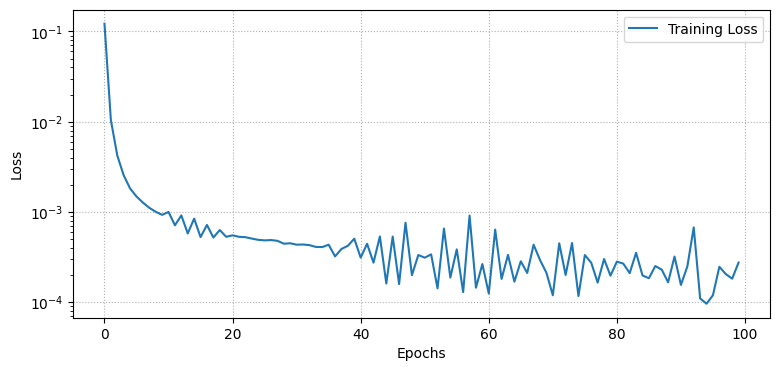

In [6]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def create_train_state(rng, learning_rate, model, x):
    params = model.init(rng, x)
    tx = optax.nadam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def mse_loss(params, batch, model):
    def loss_fn(params):
        reconstruction = model.apply(params, batch)
        return jnp.mean((batch - reconstruction) ** 2)
    return jax.value_and_grad(loss_fn)(params)

@jax.jit
def train_step(state, batch):
    loss, grads = mse_loss(state.params, batch, Autoencoder())
    state = state.apply_gradients(grads=grads)
    return state, loss

# Set training parameters
n_epochs = 100
batch_size = 128
learning_rate = 1e-3

# Initialize model and state
rng = jax.random.PRNGKey(0)
x = jnp.ones((batch_size, TIME_STEPS, 1))
state = create_train_state(rng, learning_rate, Autoencoder(), x)

# Training loop
losses = []

for epoch in tqdm(range(n_epochs)):
    epoch_losses = []
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        if x_batch.shape[0] != batch_size:  # Skip the last batch if it is smaller than batch_size
            continue
        state, loss = train_step(state, x_batch)
        epoch_losses.append(loss)
    losses.append(np.mean(epoch_losses))

# Plot the training loss curve
plt.figure(figsize=(9, 4))
plt.semilogy(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(linestyle=":")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


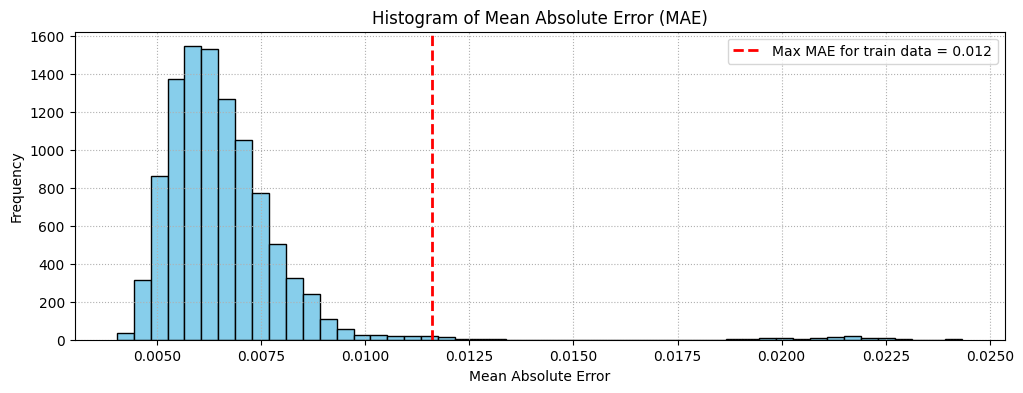

In [7]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Function to calculate MAE
def calculate_mae(params, data, model):
    reconstructed = model.apply(params, data)
    mae = jnp.mean(jnp.abs(data - reconstructed), axis=(1, 2))
    return mae

# Calculate MAE for x_train
mae_train = calculate_mae(state.params, x_train, Autoencoder())
treshold = jnp.max(mae_train)

# Calculate MAE for x_full
mae_full = calculate_mae(state.params, x_full, Autoencoder())

# Plot histogram of MAE for x_full
plt.figure(figsize=(12, 4))
plt.hist(mae_full, bins=50, color='skyblue', edgecolor='black')
plt.axvline(treshold, color='red', linestyle='dashed', linewidth=2, label=f'Max MAE for train data = {treshold:.3f}')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Absolute Error (MAE)')
plt.legend()
plt.grid(linestyle=":")
plt.show()


### Compare recontruction

Just for fun, let's see how our model has recontructed the random sample from the dataset.

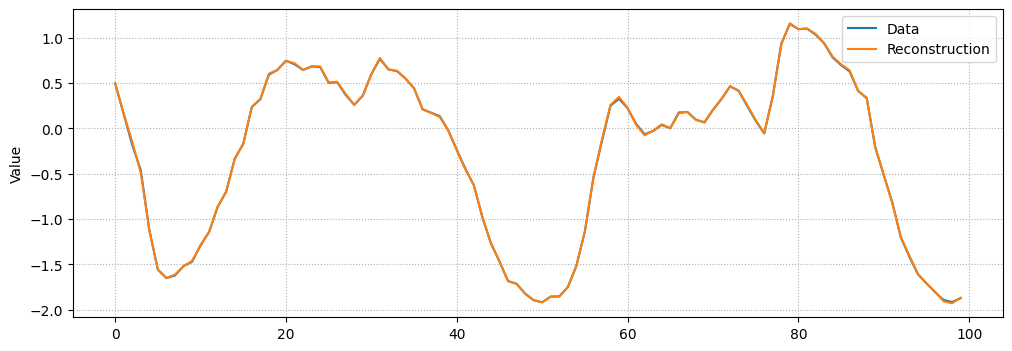

In [8]:
# Checking how the first sequence is learnt
index = np.random.randint(len(x_full))

plt.figure(figsize=(12, 4))
plt.plot(x_full[index], label="Data")
prediction =  model.apply(state.params, x_full[index])
plt.plot(prediction, label="Reconstruction")
plt.ylabel("Value")
plt.xlabel("")
plt.legend()
plt.grid(linestyle=":")
plt.show()

## Plot anomalies

In [9]:
import plotly.graph_objs as go
import pandas as pd
import numpy as np

# Load the dataset
# url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
# df = pd.read_csv(url, parse_dates=True, index_col="timestamp")
# df_normalized = df
# df_normalized['value'] = (df['value'] - df['value'].mean()) / df['value'].std()

# Define the anomalies
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# Create the plot
fig = go.Figure()

# Add the main trace
fig.add_trace(go.Scatter(x=df_normalized.index, y=df_normalized['value'], mode='lines', name='Taxi Passengers'))

# Add anomaly points with unique markers
marker = 'square'
for (label, date) in anomalies.items():
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers+text',
        name=label,
        text=label,
        textposition="top center",
        marker=dict(symbol=marker, size=10, color='red')
    ))

anomaly_indices = np.where(mae_full > treshold)[0]

# Add predicted anomalies with red markers
for i in anomaly_indices:
    date = df_normalized.index[int(i + TIME_STEPS/2)]
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers',
        name='Predicted Anomaly' if i == anomaly_indices[0] else None,
        legendgroup='Predicted Anomaly',
        marker=dict(symbol='x', size=10, color='red'),
        showlegend = bool(i == anomaly_indices[0]),
    ))

# Update layout
fig.update_layout(
    title='New York City Taxi Passengers with Anomalies Highlighted',
    xaxis_title='Date',
    template='plotly_white'
)

# Show the figure
plotly_config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

# Show the figure with the specified config
fig.show(config=plotly_config)

fig.write_html(
    "./anomaly_detection.html",
    config=plotly_config,
    include_plotlyjs="cdn",
    full_html=False,
)

As we can see, the method has detected 4 out of 5 anomalies, which is not bad result, given the simplicity of the solution and the complexity of the data!

# Exercise:

The default solution is nadam and after training it can detect 4 out of 5 anomalies. Train any other method(s), which ensures at least detecting 3 out of 5 anomalies while being approximately the same on the final train loss.

You can use any default optimizer from [optax](https://optax.readthedocs.io/en/latest/api/optimizers.html) or learning rate [schedulers](https://optax.readthedocs.io/en/latest/api/optimizer_schedules.html).

In [29]:
dataset_size = x_train.shape[0]

100%|██████████| 300/300 [00:18<00:00, 16.28it/s]


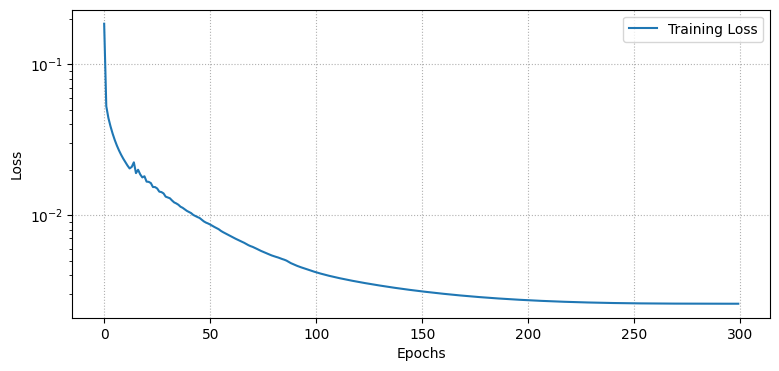

In [58]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def create_train_state(rng, learning_rate, model, x, total_steps):
    params = model.init(rng, x)

    schedule_fn = optax.cosine_decay_schedule(
        init_value=learning_rate,
        decay_steps=total_steps,
        alpha=0.0
    )
    tx = optax.chain(
        optax.sgd(learning_rate=schedule_fn, momentum=0.01)
    )

    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)


def mse_loss(params, batch, model):
    def loss_fn(params):
        reconstruction = model.apply(params, batch)
        return jnp.mean((batch - reconstruction) ** 2)
    return jax.value_and_grad(loss_fn)(params)

@jax.jit
def train_step(state, batch):
    loss, grads = mse_loss(state.params, batch, Autoencoder())
    state = state.apply_gradients(grads=grads)
    return state, loss

# Set training parameters
n_epochs = 300
batch_size = 256
learning_rate = 1e-2


total_steps = n_epochs * (dataset_size // batch_size)

# Initialize model and state
rng = jax.random.PRNGKey(0)
x = jnp.ones((batch_size, TIME_STEPS, 1))
state = create_train_state(rng, learning_rate, Autoencoder(), x, total_steps)

# Training loop
losses = []

for epoch in tqdm(range(n_epochs)):
    epoch_losses = []
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        if x_batch.shape[0] != batch_size:  # Skip the last batch if it is smaller than batch_size
            continue
        state, loss = train_step(state, x_batch)
        epoch_losses.append(loss)
    losses.append(np.mean(epoch_losses))

# Plot the training loss curve
plt.figure(figsize=(9, 4))
plt.semilogy(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(linestyle=":")
plt.legend()
plt.show()

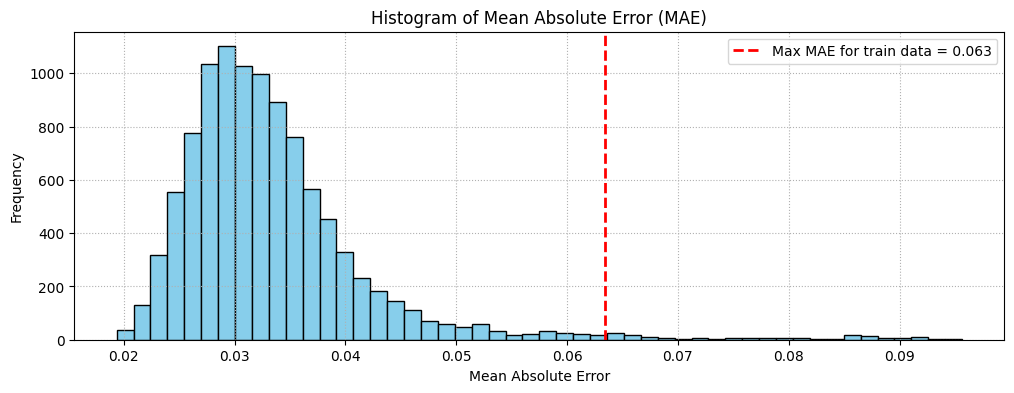

In [60]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Function to calculate MAE
def calculate_mae(params, data, model):
    reconstructed = model.apply(params, data)
    mae = jnp.mean(jnp.abs(data - reconstructed), axis=(1, 2))
    return mae

# Calculate MAE for x_train
mae_train = calculate_mae(state.params, x_train, Autoencoder())
treshold = jnp.max(mae_train)

# Calculate MAE for x_full
mae_full = calculate_mae(state.params, x_full, Autoencoder())

# Plot histogram of MAE for x_full
plt.figure(figsize=(12, 4))
plt.hist(mae_full, bins=50, color='skyblue', edgecolor='black')
plt.axvline(treshold, color='red', linestyle='dashed', linewidth=2, label=f'Max MAE for train data = {treshold:.3f}')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Absolute Error (MAE)')
plt.legend()
plt.grid(linestyle=":")
plt.show()


In [61]:
import plotly.graph_objs as go
import pandas as pd
import numpy as np

# Load the dataset
# url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
# df = pd.read_csv(url, parse_dates=True, index_col="timestamp")
# df_normalized = df
# df_normalized['value'] = (df['value'] - df['value'].mean()) / df['value'].std()

# Define the anomalies
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# Create the plot
fig = go.Figure()

# Add the main trace
fig.add_trace(go.Scatter(x=df_normalized.index, y=df_normalized['value'], mode='lines', name='Taxi Passengers'))

# Add anomaly points with unique markers
marker = 'square'
for (label, date) in anomalies.items():
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers+text',
        name=label,
        text=label,
        textposition="top center",
        marker=dict(symbol=marker, size=10, color='red')
    ))

anomaly_indices = np.where(mae_full > treshold)[0]

# Add predicted anomalies with red markers
for i in anomaly_indices:
    date = df_normalized.index[int(i + TIME_STEPS/2)]
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers',
        name='Predicted Anomaly' if i == anomaly_indices[0] else None,
        legendgroup='Predicted Anomaly',
        marker=dict(symbol='x', size=10, color='red'),
        showlegend = bool(i == anomaly_indices[0]),
    ))

# Update layout
fig.update_layout(
    title='New York City Taxi Passengers with Anomalies Highlighted',
    xaxis_title='Date',
    template='plotly_white'
)

# Show the figure
plotly_config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

# Show the figure with the specified config
fig.show(config=plotly_config)

fig.write_html(
    "./anomaly_detection.html",
    config=plotly_config,
    include_plotlyjs="cdn",
    full_html=False,
)

100%|██████████| 300/300 [00:29<00:00, 10.29it/s]


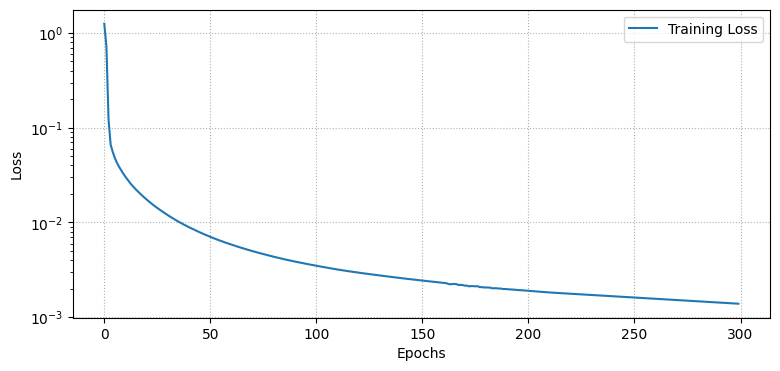

In [101]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def create_train_state(rng, learning_rate, model, x):
    params = model.init(rng, x)
    tx = optax.adadelta(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)


def mse_loss(params, batch, model):
    def loss_fn(params):
        reconstruction = model.apply(params, batch)
        return jnp.mean((batch - reconstruction) ** 2)
    return jax.value_and_grad(loss_fn)(params)

@jax.jit
def train_step(state, batch):
    loss, grads = mse_loss(state.params, batch, Autoencoder())
    state = state.apply_gradients(grads=grads)
    return state, loss

# Set training parameters
n_epochs = 300
batch_size = 128
learning_rate = 8e-3


total_steps = n_epochs * (dataset_size // batch_size)

# Initialize model and state
rng = jax.random.PRNGKey(0)
x = jnp.ones((batch_size, TIME_STEPS, 1))
state = create_train_state(rng, learning_rate, Autoencoder(), x)

# Training loop
losses = []

for epoch in tqdm(range(n_epochs)):
    epoch_losses = []
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        if x_batch.shape[0] != batch_size:  # Skip the last batch if it is smaller than batch_size
            continue
        state, loss = train_step(state, x_batch)
        epoch_losses.append(loss)
    losses.append(np.mean(epoch_losses))

# Plot the training loss curve
plt.figure(figsize=(9, 4))
plt.semilogy(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(linestyle=":")
plt.legend()
plt.show()

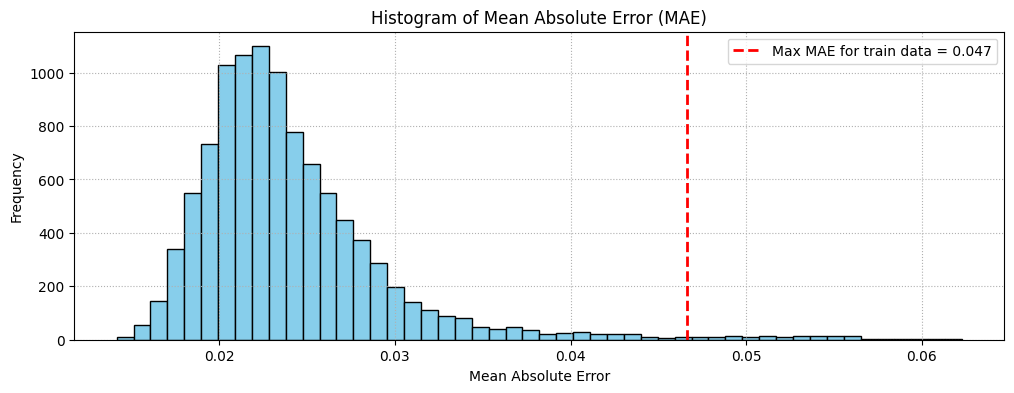

In [102]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Function to calculate MAE
def calculate_mae(params, data, model):
    reconstructed = model.apply(params, data)
    mae = jnp.mean(jnp.abs(data - reconstructed), axis=(1, 2))
    return mae

# Calculate MAE for x_train
mae_train = calculate_mae(state.params, x_train, Autoencoder())
treshold = jnp.max(mae_train)

# Calculate MAE for x_full
mae_full = calculate_mae(state.params, x_full, Autoencoder())

# Plot histogram of MAE for x_full
plt.figure(figsize=(12, 4))
plt.hist(mae_full, bins=50, color='skyblue', edgecolor='black')
plt.axvline(treshold, color='red', linestyle='dashed', linewidth=2, label=f'Max MAE for train data = {treshold:.3f}')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Absolute Error (MAE)')
plt.legend()
plt.grid(linestyle=":")
plt.show()


In [103]:
import plotly.graph_objs as go
import pandas as pd
import numpy as np

# Load the dataset
# url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
# df = pd.read_csv(url, parse_dates=True, index_col="timestamp")
# df_normalized = df
# df_normalized['value'] = (df['value'] - df['value'].mean()) / df['value'].std()

# Define the anomalies
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# Create the plot
fig = go.Figure()

# Add the main trace
fig.add_trace(go.Scatter(x=df_normalized.index, y=df_normalized['value'], mode='lines', name='Taxi Passengers'))

# Add anomaly points with unique markers
marker = 'square'
for (label, date) in anomalies.items():
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers+text',
        name=label,
        text=label,
        textposition="top center",
        marker=dict(symbol=marker, size=10, color='red')
    ))

anomaly_indices = np.where(mae_full > treshold)[0]

# Add predicted anomalies with red markers
for i in anomaly_indices:
    date = df_normalized.index[int(i + TIME_STEPS/2)]
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers',
        name='Predicted Anomaly' if i == anomaly_indices[0] else None,
        legendgroup='Predicted Anomaly',
        marker=dict(symbol='x', size=10, color='red'),
        showlegend = bool(i == anomaly_indices[0]),
    ))

# Update layout
fig.update_layout(
    title='New York City Taxi Passengers with Anomalies Highlighted',
    xaxis_title='Date',
    template='plotly_white'
)

# Show the figure
plotly_config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

# Show the figure with the specified config
fig.show(config=plotly_config)

fig.write_html(
    "./anomaly_detection.html",
    config=plotly_config,
    include_plotlyjs="cdn",
    full_html=False,
)

3/5 есть